# Construct the training data into Data format

In [22]:
import sys
sys.path.append("../src")

import torch
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from torch_geometric.data import Data
from reachability_model_function import build_graph_reachability
from dataset_function import generate_labeled_route_no_sides
from torch_geometric.loader import DataLoader
from reachability_model_function import ReachabilityGNN, ReachabilityGNNv11
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight
from reachability_model_function import FocalLoss
from reachability_model_function import plot_graph_prediction
from torch_geometric.data import Batch
from reachability_model_function import simulate_climb_to_goal
from dataset_function import plot_route_with_grab
from sklearn.metrics import f1_score

In [2]:
dataset = pd.read_csv("../data/reachability_dataset_812.csv")
dataset = dataset.dropna()

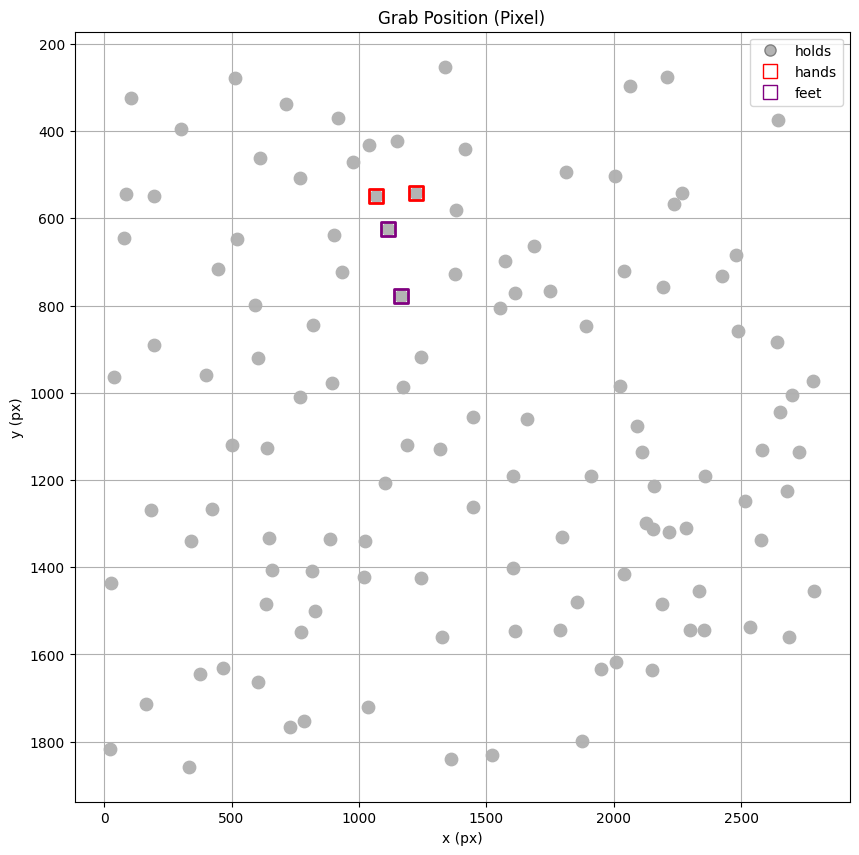

In [3]:
sample = dataset.iloc[77770].apply(literal_eval)
plot_route_with_grab(sample.route, sample.hands, sample.feet)

In [3]:
for name in dataset.columns:
    dataset[name] = dataset[name].apply(literal_eval)

In [4]:
# graph_list: each graph is a training sample
graph_list = []

for _, row in dataset.iterrows():
    labels = generate_labeled_route_no_sides(row["route"], row["hands"], row["feet"], row["climber"])
    if labels.count(0) / len(labels) < 0.95:
        data = build_graph_reachability(row["route"], row["hands"], row["feet"], row["climber"], labels)
        graph_list.append(data)

In [5]:
len(graph_list)

89461

In [6]:
from collections import Counter

def key_graph(g, prec=0):
    import numpy as np, torch
    def to_np(x): return x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)
    def key_pts(pts):
        if pts is None or len(pts)==0: return ()
        arr = to_np(pts)
        arr = [(round(float(x),prec), round(float(y),prec)) for x,y in arr]
        return tuple(sorted(arr))
    coords = key_pts(to_np(g.x)[:, :2])
    hands  = key_pts(getattr(g,'hands',None))
    feet   = key_pts(getattr(g,'feet',None))
    climber= tuple(round(float(v),prec) for v in to_np(getattr(g,'climber',None)).reshape(-1)) if hasattr(g,'climber') else ()
    return (coords, hands, feet, climber)

keys = [key_graph(g, prec=0) for g in graph_list]
cnt = Counter(keys)
dup_rate = 1 - (len(cnt) / len(graph_list))
print(f"重复率: {dup_rate:.1%}, 重复簇≥2个的数量: {sum(v>=2 for v in cnt.values())}")

重复率: 38.9%, 重复簇≥2个的数量: 13998


In [7]:
def _to_np(t):
    if t is None: return None
    return t.detach().cpu().numpy() if isinstance(t, torch.Tensor) else np.asarray(t)

def _pts_key(pts, precision=0):
    if pts is None or len(pts)==0: return ()
    arr = _to_np(pts)
    arr = [(round(float(x),precision), round(float(y),precision)) for x,y in arr]
    return tuple(sorted(arr))  # 顺序无关

def graph_signature(g: Data, precision=0):
    coords  = _pts_key(_to_np(g.x)[:, :2], precision)            # 只用 (x,y)
    hands   = _pts_key(getattr(g,'hands',None), precision)
    feet    = _pts_key(getattr(g,'feet',None), precision)
    climber = tuple(round(float(v),precision) 
                    for v in _to_np(getattr(g,'climber',None)).reshape(-1))
    return (coords, hands, feet, climber)

def dedupe_graph_list(graph_list, precision=0):
    sig2first = {}
    keep_indices, groups = [], {}
    for i, g in enumerate(graph_list):
        sig = graph_signature(g, precision)
        if sig not in sig2first:
            sig2first[sig] = i
        groups.setdefault(sig2first[sig], []).append(i)
    keep_indices = sorted(sig2first.values())
    unique_list = [graph_list[i] for i in keep_indices]
    duplicate_groups = [v for k,v in sorted(groups.items(), key=lambda kv: keep_indices.index(kv[0]))]
    return unique_list, keep_indices, duplicate_groups

unique_graphs, keep_idx, dup_groups = dedupe_graph_list(graph_list, precision=0)
print(f"Original: {len(graph_list)}, After deduplication: {len(unique_graphs)}")
# 看看有哪些簇出现重复
dup_only = [grp for grp in dup_groups if len(grp) > 1]
print(f"Number of repeated clusters: {len(dup_only)}, Example of the first 3 clusters: {dup_only[:3]}")
# 如果要替换原列表：
graph_list = unique_graphs


Original: 89461, After deduplication: 54655
Number of repeated clusters: 13998, Example of the first 3 clusters: [[3, 19], [6, 17], [8, 15]]


In [8]:
# Save the graph_list to local
torch.save(graph_list, "graph_list_global812_armleg_newx.pt")

# Visualise the Graph

In [2]:
graph_list = torch.load("graph_list_global812_armleg_newx.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_36788\1890493496.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global812_armleg_newx.pt

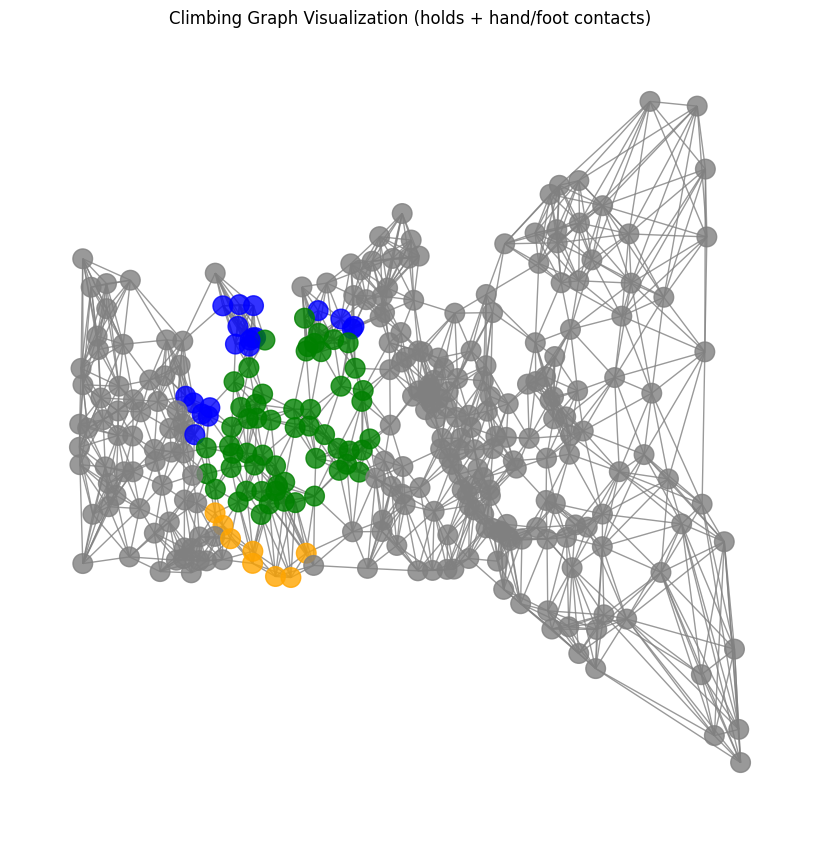

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import torch

data = graph_list[8880]
G = to_networkx(data, to_undirected=True)

pos = {i: (float(data.x[i,0]), -float(data.x[i,1])) for i in range(data.num_nodes)}

palette = {0:"gray", 1:"blue", 2:"orange", 3:"green"}
node_colors = [palette.get(int(lbl), "gray") for lbl in data.y.tolist()]

plt.figure(figsize=(8,8))
nx.draw(G, pos, node_color=node_colors, node_size=200, edge_color="gray", with_labels=False, alpha=0.8)

num_nodes = data.num_nodes
def safe_idx(t):
    idx = torch.as_tensor(t).view(-1).long()
    idx = idx[(idx >= 0) & (idx < num_nodes)]   
    return idx.tolist()

hands_idx = safe_idx(data.hands)
feet_idx  = safe_idx(data.feet)

nx.draw_networkx_nodes(G, pos, nodelist=hands_idx, node_color="none",
                       edgecolors="red", node_size=450, linewidths=2)
nx.draw_networkx_nodes(G, pos, nodelist=feet_idx, node_color="none",
                       edgecolors="purple", node_size=450, linewidths=2)

plt.title("Climbing Graph Visualization (holds + hand/foot contacts)")
plt.show()


# Train the Model

In [3]:
# Load pt file
graph_list = torch.load("graph_list_global812_armleg_newx.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_36788\2077585787.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global812_armleg_newx.pt

In [4]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)

In [5]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [15]:
all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float)

print("Used Weights:", weights)

Used Weights: tensor([0.1814, 3.1246, 4.2125, 2.2336])


# Use Balanced

In [23]:
all_train_labels = np.concatenate([g.y.cpu().numpy() for g in train_data]) 

classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_train_labels)

weights = np.clip(weights, a_min=0.5, a_max=5.0)
weights = weights / weights.mean()
weights = np.clip(weights, a_min=0.5, a_max=5.0)

weights = torch.tensor(weights, dtype=torch.float).to(device)

print("Balanced weights:", weights)

Balanced weights: tensor([0.5000, 1.5584, 1.5584, 0.7275], device='cuda:0')


In [24]:
# shuffle=True: Shuffle the order of the graph at each epoch to enhance the model's generalisation ability.
loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=True)
model = ReachabilityGNNv11().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

# CrossEntropy
# loss_fn = nn.CrossEntropyLoss(weight=weights)

# Focal Loss
loss_fn = FocalLoss(gamma=2.0, weight=weights)

def evaluate(model, loader, loss_fn, device):
    model.eval()
    total_loss, n_batches = 0.0, 0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)                 
            loss = loss_fn(out, batch.y)        
            total_loss += loss.item()
            n_batches += 1

            pred = out.argmax(dim=1).cpu().numpy()
            true = batch.y.cpu().numpy()
            all_preds.extend(pred)
            all_trues.extend(true)

    avg_loss = total_loss / max(1, n_batches)
    macro_f1 = f1_score(all_trues, all_preds, average='macro')
    return avg_loss, macro_f1

best_f1 = -1.0
patience, bad_epochs = 8, 0
best_ckpt = "best_reachability_v11.pt"

for epoch in range(50):
    total_loss = 0
    model.train()
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        total_loss += loss.item()

    val_loss, val_macro_f1 = evaluate(model, val_loader, loss_fn, device)

    scheduler.step()  # learning rate decay
    current_lr = scheduler.get_last_lr()[0]  

    print(f"Epoch {epoch:02d} | "
          f"train_loss: {total_loss:.4f} | "
          f"val_loss: {val_loss:.4f} | "
          f"val_macroF1: {val_macro_f1:.4f} | "
          f"LR: {current_lr:.5f} | "
          f"LossFn: {loss_fn.__class__.__name__}")
    
    if val_macro_f1 > best_f1:
        best_f1 = val_macro_f1
        bad_epochs = 0
        torch.save(model.state_dict(), best_ckpt)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stop at epoch {epoch} (best val macro-F1={best_f1:.4f}).")
            break

print(f"Training done. Best checkpoint saved at '{best_ckpt}' with val macro-F1={best_f1:.4f}.")

Epoch 00 | train_loss: 591.6854 | val_loss: 0.0733 | val_macroF1: 0.6109 | LR: 0.00100 | LossFn: FocalLoss
Epoch 01 | train_loss: 325.6484 | val_loss: 0.0469 | val_macroF1: 0.7068 | LR: 0.00100 | LossFn: FocalLoss
Epoch 02 | train_loss: 225.9176 | val_loss: 0.0343 | val_macroF1: 0.7733 | LR: 0.00100 | LossFn: FocalLoss
Epoch 03 | train_loss: 133.1506 | val_loss: 0.0257 | val_macroF1: 0.8203 | LR: 0.00100 | LossFn: FocalLoss
Epoch 04 | train_loss: 116.7501 | val_loss: 0.0148 | val_macroF1: 0.8353 | LR: 0.00100 | LossFn: FocalLoss
Epoch 05 | train_loss: 102.6847 | val_loss: 0.0240 | val_macroF1: 0.8327 | LR: 0.00100 | LossFn: FocalLoss
Epoch 06 | train_loss: 92.3775 | val_loss: 0.0277 | val_macroF1: 0.8327 | LR: 0.00100 | LossFn: FocalLoss
Epoch 07 | train_loss: 83.3012 | val_loss: 0.0214 | val_macroF1: 0.8629 | LR: 0.00100 | LossFn: FocalLoss
Epoch 08 | train_loss: 79.4794 | val_loss: 0.0165 | val_macroF1: 0.8636 | LR: 0.00100 | LossFn: FocalLoss
Epoch 09 | train_loss: 72.1785 | val_los

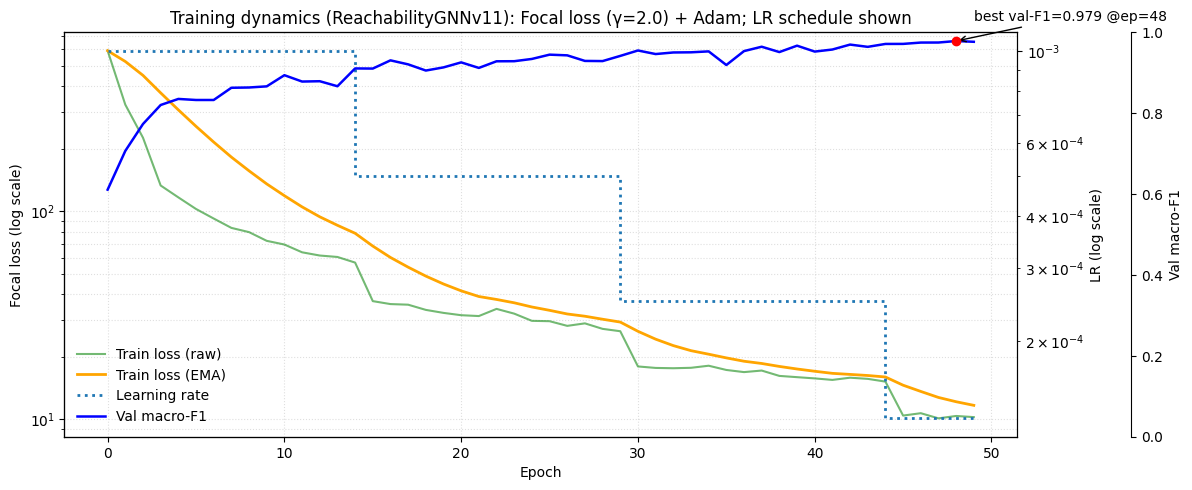

In [37]:
import re, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

log_path = Path("train_log.txt")
use_f1_as_second_curve = True

ep, train_loss, val_loss, val_f1, lrs = [], [], [], [], []

pat = re.compile(
    r"Epoch\s+(\d+)\s*\|\s*train_loss:\s*([0-9.eE+-]+)\s*\|\s*val_loss:\s*([0-9.eE+-]+)\s*\|\s*val_macroF1:\s*([0-9.eE+-]+)\s*\|\s*LR:\s*([0-9.eE+-]+)"
)

with open(log_path, "r", encoding="utf-8") as f:
    for line in f:
        m = pat.search(line)
        if m:
            ep.append(int(m.group(1)))
            train_loss.append(float(m.group(2)))
            val_loss.append(float(m.group(3)))
            val_f1.append(float(m.group(4)))
            lrs.append(float(m.group(5)))

ep = np.array(ep)
train_loss = np.array(train_loss, dtype=float)
val_loss   = np.array(val_loss,   dtype=float)
val_f1     = np.array(val_f1,     dtype=float)
lrs        = np.array(lrs,        dtype=float)

if len(ep) == 0:
    raise RuntimeError("Fail!")

def ema(arr, alpha=0.25):
    out, s = [], None
    for v in arr:
        s = v if s is None else alpha*v + (1-alpha)*s
        out.append(s)
    return np.array(out, dtype=float)

train_loss_ema = ema(train_loss, alpha=0.25)

if use_f1_as_second_curve:
    best_idx = int(np.argmax(val_f1))
    best_text = f"best val-F1={val_f1[best_idx]:.3f} @ep={ep[best_idx]}"
else:
    best_idx = int(np.argmin(val_loss))
    best_text = f"best val-loss={val_loss[best_idx]:.4f} @ep={ep[best_idx]}"

fig, ax = plt.subplots(figsize=(12, 5))

ax.set_yscale("log")
ax.plot(ep, train_loss, color='green', alpha=0.55, label="Train loss (raw)")
ax.plot(ep, train_loss_ema, color='orange', linewidth=2.0, label="Train loss (EMA)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Focal loss (log scale)")
ax.grid(True, which="both", linestyle=":", alpha=0.4)

ax_lr = ax.twinx()
ax_lr.set_yscale("log")
ax_lr.step(ep, lrs, where="post", linestyle=":", linewidth=2.0, label="Learning rate")
ax_lr.set_ylabel("LR (log scale)")

ax2 = ax.twinx()
ax2.spines["right"].set_position(("axes", 1.12))
if use_f1_as_second_curve:
    ax2.plot(ep, val_f1, linewidth=1.8, color='blue', label="Val macro-F1")
    ax2.set_ylim(0.0, 1.0)
    ax2.set_ylabel("Val macro-F1")
    ax2.scatter(ep[best_idx], val_f1[best_idx], zorder=5, color="red")
    ax2.annotate(best_text, xy=(ep[best_idx], val_f1[best_idx]),
                 xytext=(ep[best_idx]+1, val_f1[best_idx]+0.05),
                 arrowprops=dict(arrowstyle="->"))
else:
    ax2.set_yscale("log")
    ax2.plot(ep, val_loss, linewidth=1.8, label="Val loss")
    ax2.set_ylabel("Val loss (log scale)")
    ax2.scatter(ep[best_idx], val_loss[best_idx], zorder=5)
    ax2.annotate(best_text, xy=(ep[best_idx], val_loss[best_idx]),
                 xytext=(ep[best_idx]+1, val_loss[best_idx]*1.3),
                 arrowprops=dict(arrowstyle="->"))

# 合并图例
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax_lr.get_legend_handles_labels()
h3, l3 = ax2.get_legend_handles_labels()
ax.legend(h1+h2+h3, l1+l2+l3, loc="lower left", frameon=False)

ax.set_title("Training dynamics (ReachabilityGNNv11): Focal loss (γ=2.0) + Adam; LR schedule shown")
plt.tight_layout()
plt.show()
# plt.savefig("training_dynamics_from_log.png", dpi=300)


In [14]:
model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g]).to(device)     
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 4415148, 3: 569185, 1: 243915, 2: 86858})


In [15]:
torch.save(model.state_dict(),"reachability_model11_812_span_newx.pt")

# Visualisation

In [38]:
import sys
sys.path.append("../src")
import torch
from reachability_model_function import ReachabilityGNNv11
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
# Load the model
model = ReachabilityGNNv11().to(device)
model.load_state_dict(torch.load("best_reachability_v11.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_36788\1310642771.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_reachability_v11.pt")

ReachabilityGNNv11(
  (conv1): GATConv(8, 64, heads=2)
  (conv2): GATConv(64, 64, heads=2)
  (climber_embed): Linear(in_features=6, out_features=64, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
  (flag_head): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [70]:
graph_list = torch.load("graph_list_global812_armleg_newx.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_36788\1890493496.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global812_armleg_newx.pt

In [71]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)

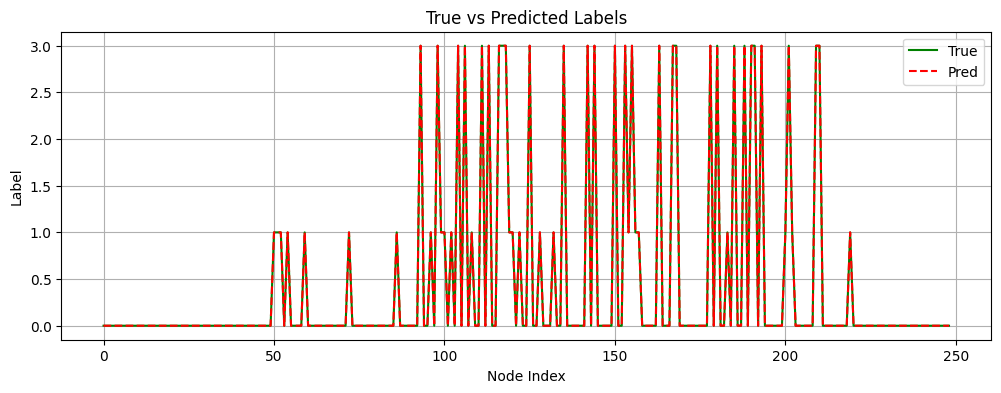

In [90]:
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
graph = test_data[200]
batch = Batch.from_data_list([graph])
batch = batch.to(device)

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [43]:
all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        batch = batch.to(device)
        out = model(batch).to(device)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

              precision    recall  f1-score   support

 unreachable       1.00      1.00      1.00   1106486
        hand       0.93      1.00      0.96     58441
        foot       0.94      1.00      0.97     19201
        both       1.00      0.98      0.99    141580

    accuracy                           1.00   1325708
   macro avg       0.97      0.99      0.98   1325708
weighted avg       1.00      1.00      1.00   1325708



# Visualise the Model Output

In [1]:
import sys
sys.path.append("../src")
import torch
from reachability_model_function import ReachabilityGNNv11
from sklearn.model_selection import  train_test_split
from reachability_model_function import plot_graph_prediction
from reachability_model_function import simulate_climb_to_goal, simulate_climb_to_goal_v2
from reachability_model_function import calculate_the_step_to_goal, calculate_the_step_to_goal_v2
from torch_geometric.data import Batch, Data
import pandas as pd
from ast import literal_eval
import numpy as np
from dataset_function import get_reach_ranges
from route_parser import pixel_dist_to_cm
from reachability_model_function import recompute_node_features_with_climber
from reachability_model_function import build_single_graph_reachability
import copy

In [2]:
graph_list = torch.load("graph_list_global812_armleg_newx.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_548\1890493496.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global812_armleg_newx.pt")

In [3]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)

In [4]:
model = ReachabilityGNNv11()
# model.load_state_dict(torch.load("reachability_model11_812_span_newx.pt"))
model.load_state_dict(torch.load("best_reachability_v11.pt"))

C:\Users\guanj\AppData\Local\Temp\ipykernel_548\3063634857.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_reachability_v11.pt"))


<All keys matched successfully>

In [46]:
# Check the climber affect
import copy
graph = test_data[300]
g1 = copy.deepcopy(graph); g1.climber[:,0]=190; recompute_node_features_with_climber(g1)
g2 = copy.deepcopy(graph); g2.climber[:,0]=160; recompute_node_features_with_climber(g2)
print("Δx =", (g1.x - g2.x).abs().sum().item())  # 应该 > 0

Δx = 112.82601928710938


# Visualisation: Same wall Different Climbers

In [92]:
# Create a new graph
walls = pd.read_csv("../data/climbing_data.csv")
walls["points"] = walls["points"].apply(literal_eval)

In [93]:
climber = {
    "height": 163.0,
    "ape_index": 0.9900,
    "flexibility": 4.000,
    "leg_len_factor": 0.5002,
    "arm_span": 163.0 * 0.9900,
    "leg_span": 163.0 * 0.5002
}
route = walls.iloc[3].points
# hands = [(22.181818181818183, 1676.3636363636363),(175.33333333333334, 1642.1666666666667)]
# feet = [(113.63636363636364, 1826.5454545454545), (77.6923076923077, 1775.0)]
# goal = (2360.25, 326.1666666666667)

hands = [(392.90909090909093, 1483.6363636363637), (349.0, 1480.3076923076924)]
feet = [(429.7692307692308, 1620.0), (175.33333333333334, 1642.1666666666667)]
goal = (2595.2727272727275, 954.9090909090909)

In [94]:
graph = build_single_graph_reachability(route, hands, feet, climber)

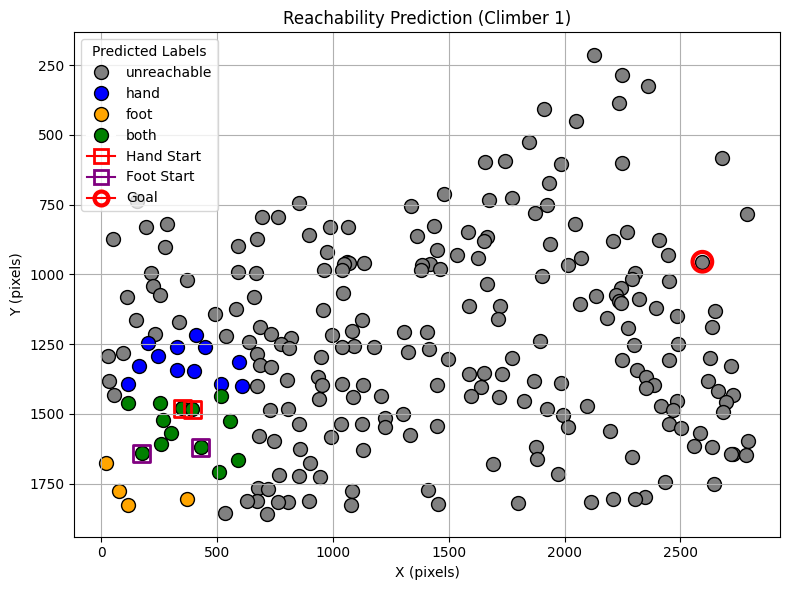

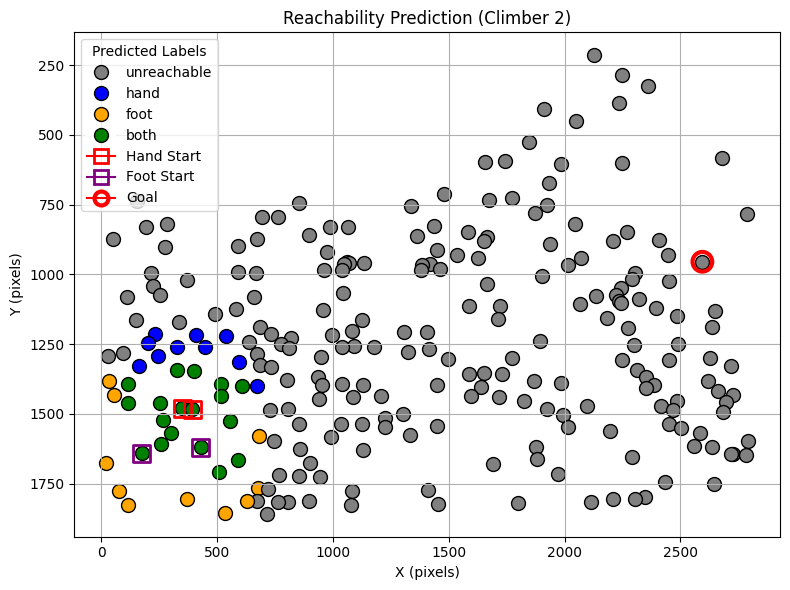

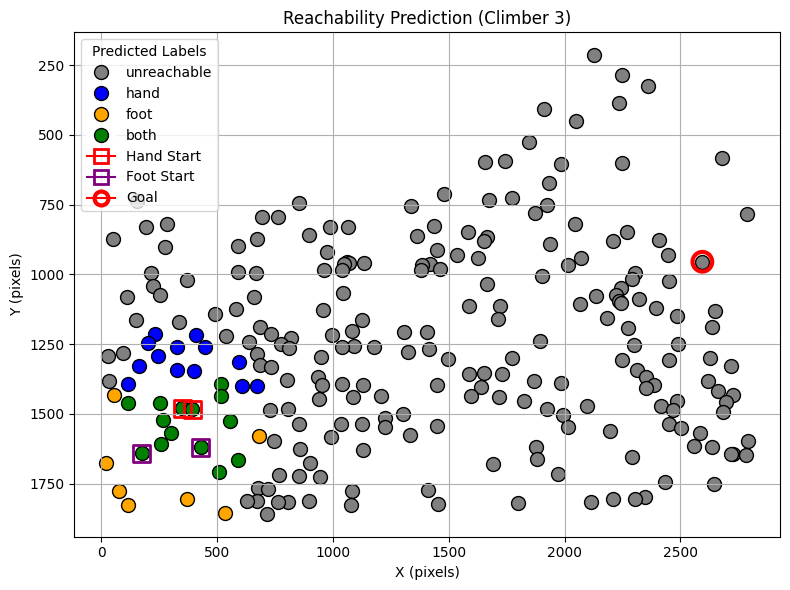

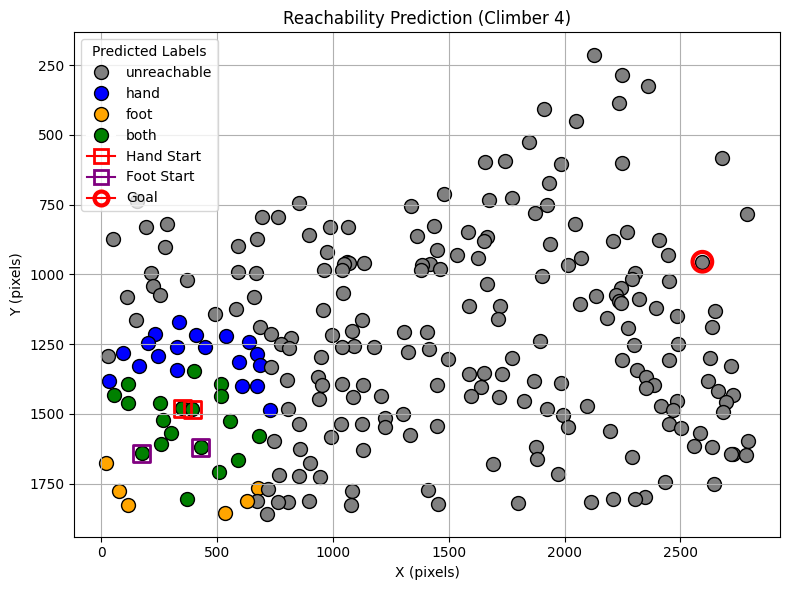

In [96]:
import copy

climber1 = torch.tensor([[163.3, 1.0, 5.0, 0.510348, 163.3, 83.3398]])
climber2 = torch.tensor([[171.6, 1.02, 6, 0.601341, 175.032, 103.19011]])
climber3 = torch.tensor([[171.6, 0.99, 6, 0.51023, 169.9434, 87.55547]])
climber4 = torch.tensor([[185.3, 1.05, 8, 0.513411, 194.565, 95.1351]])

g1 = copy.deepcopy(graph)
g1.climber = climber1
recompute_node_features_with_climber(g1)

batch1 = Batch.from_data_list([g1])
plot_graph_prediction(batch1, model, "Reachability Prediction (Climber 1)", goal)

g2 = copy.deepcopy(graph)
g2.climber = climber2
recompute_node_features_with_climber(g2)

batch2 = Batch.from_data_list([g2])
plot_graph_prediction(batch2, model, "Reachability Prediction (Climber 2)", goal)

g3 = copy.deepcopy(graph)
g3.climber = climber3
recompute_node_features_with_climber(g3)

batch3 = Batch.from_data_list([g3])
plot_graph_prediction(batch3, model, "Reachability Prediction (Climber 3)", goal)

g4 = copy.deepcopy(graph)
g4.climber = climber4
recompute_node_features_with_climber(g4)

batch4 = Batch.from_data_list([g4])
plot_graph_prediction(batch4, model, "Reachability Prediction (Climber 4)", goal)

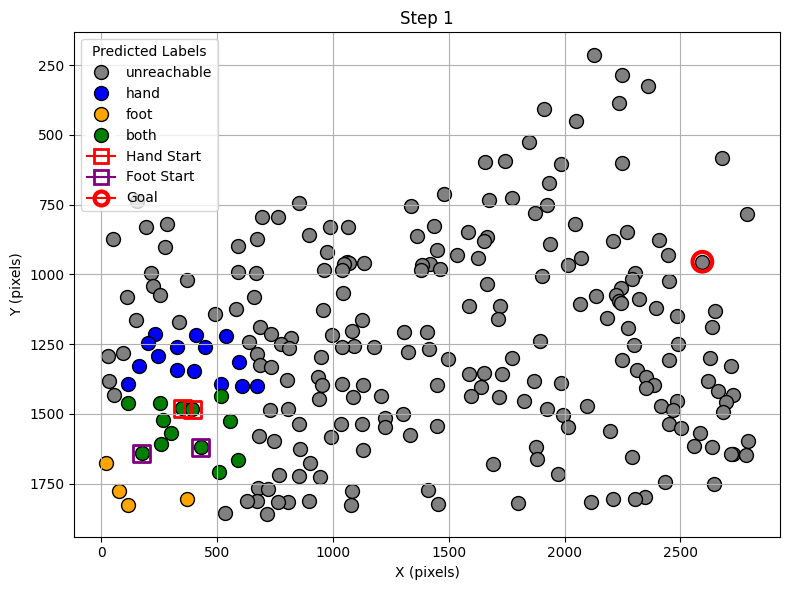

d:\bristol\final_project\Climbing_Model\model\../src\reachability_model_function.py:674: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  g.hands = torch.tensor(selected_hands, dtype=torch.float, device=device)


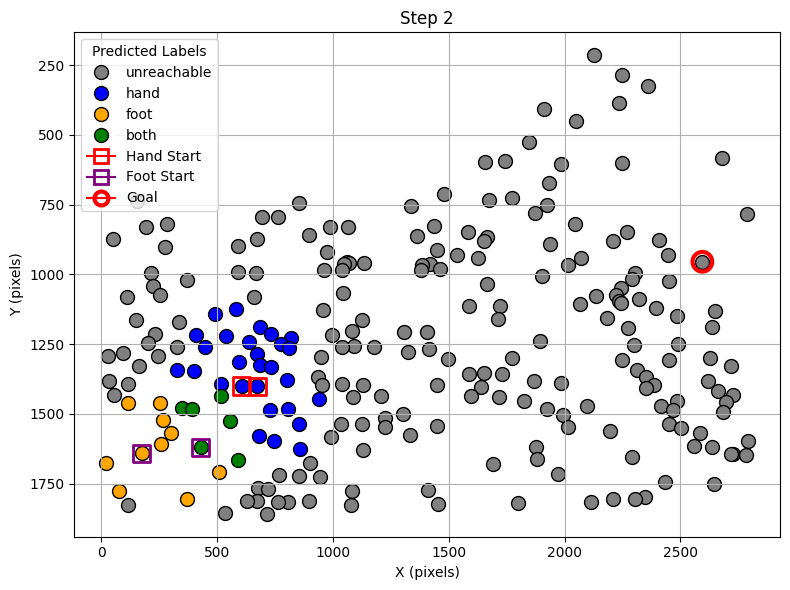

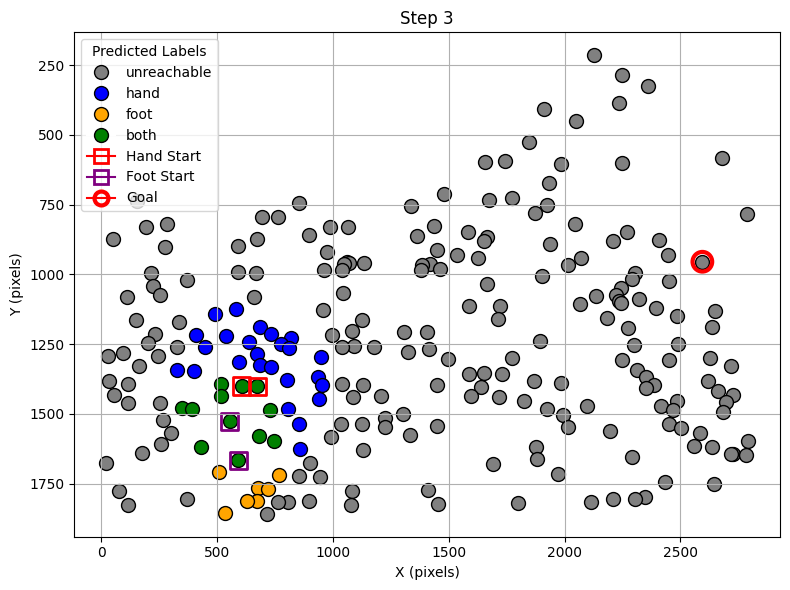

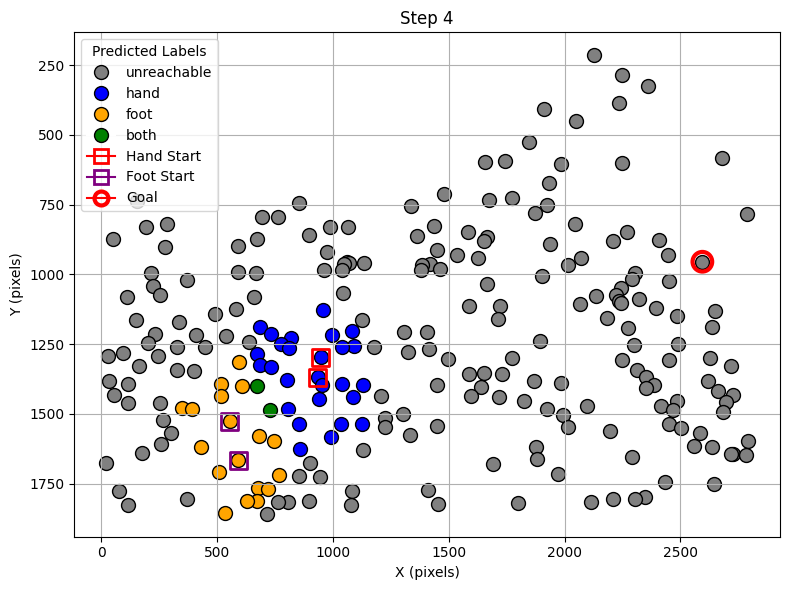

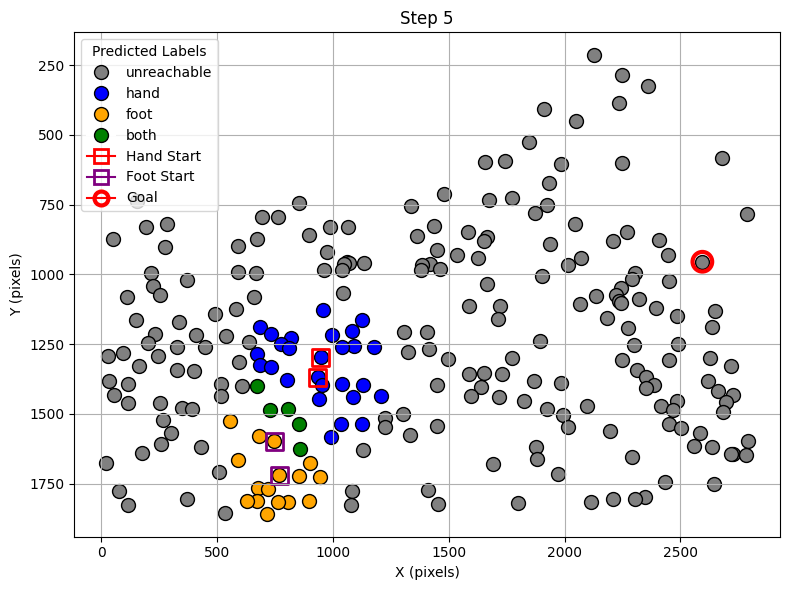

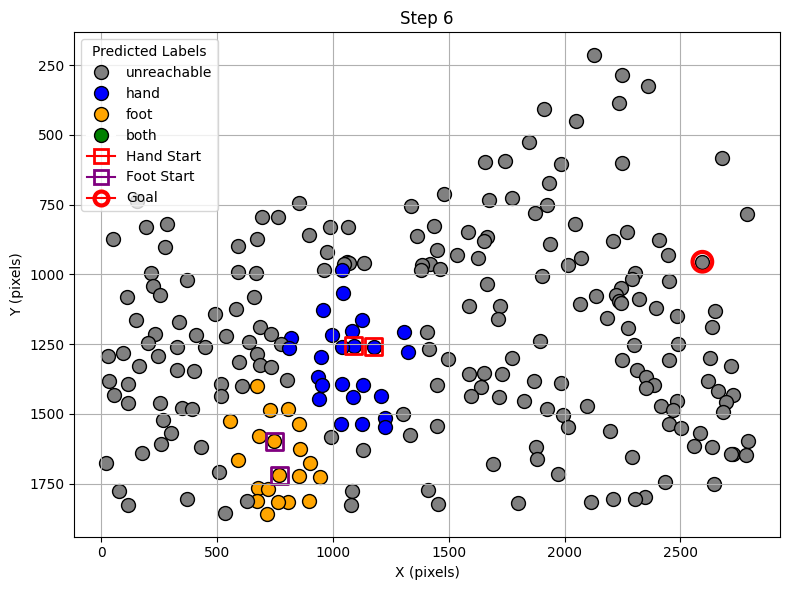

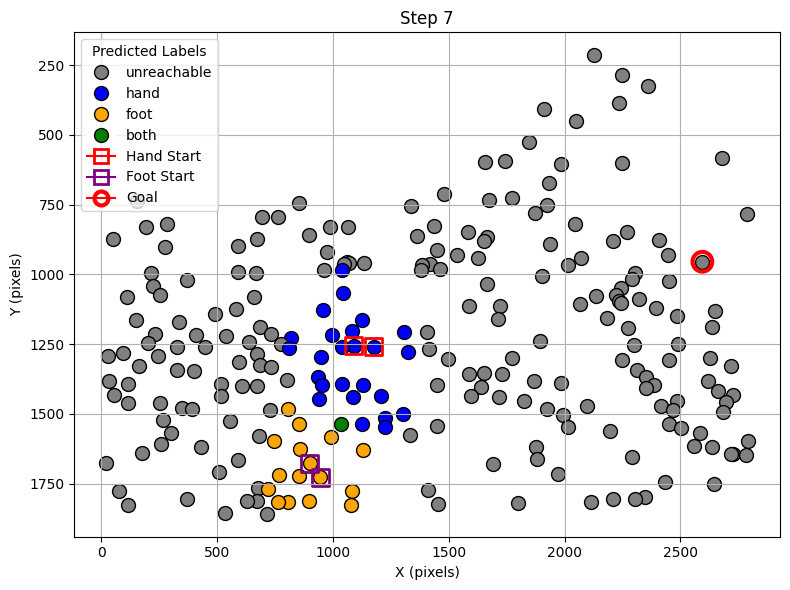

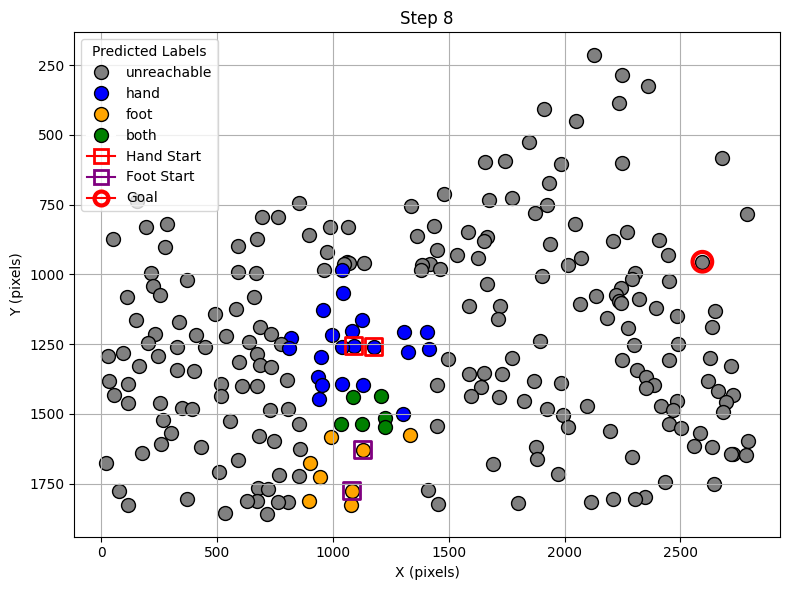

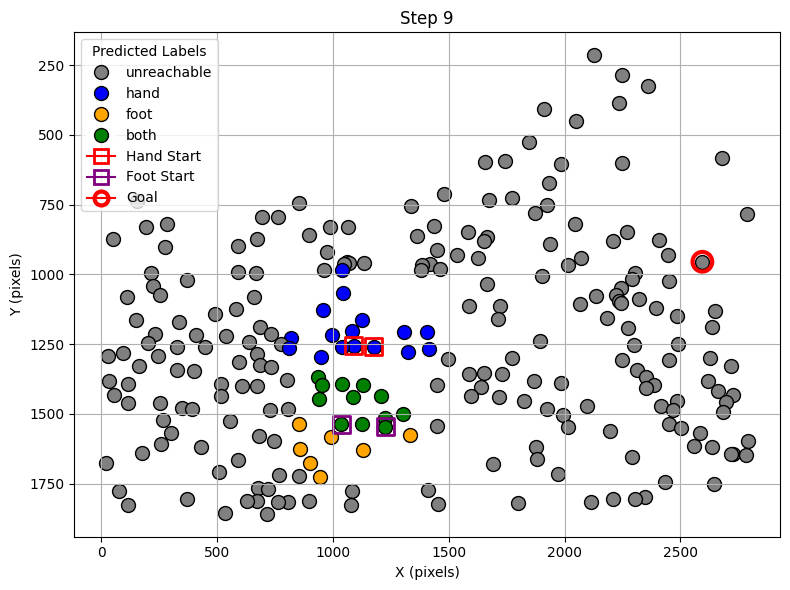

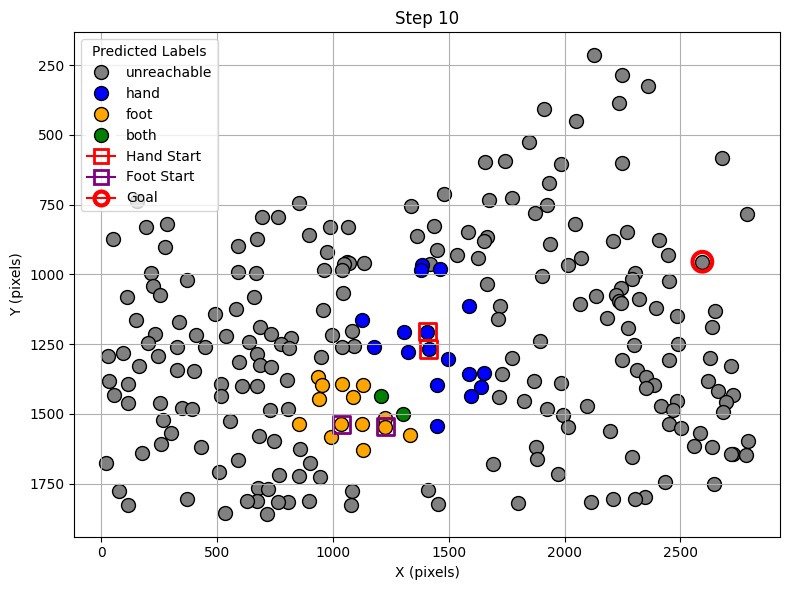

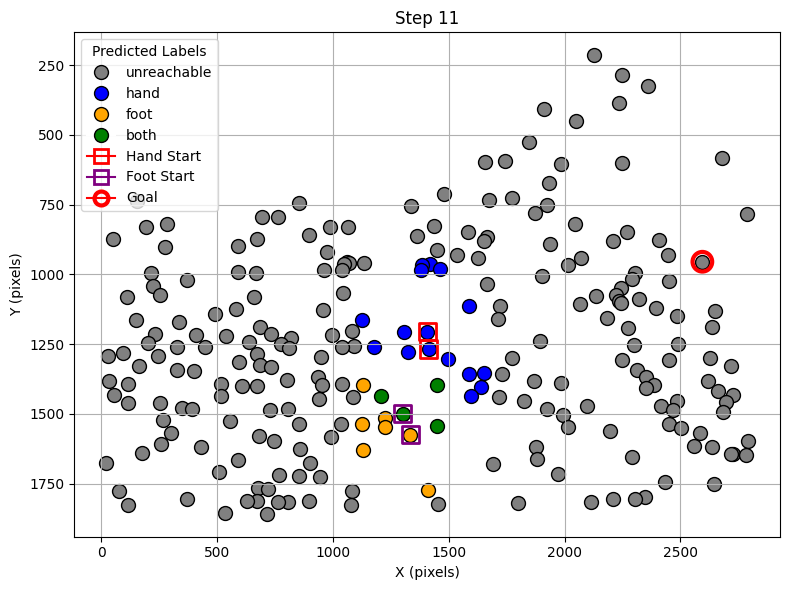

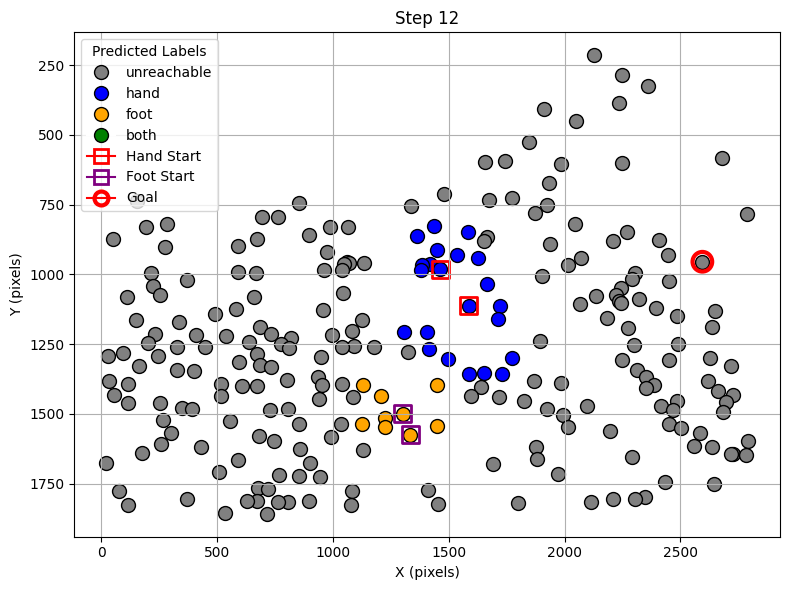

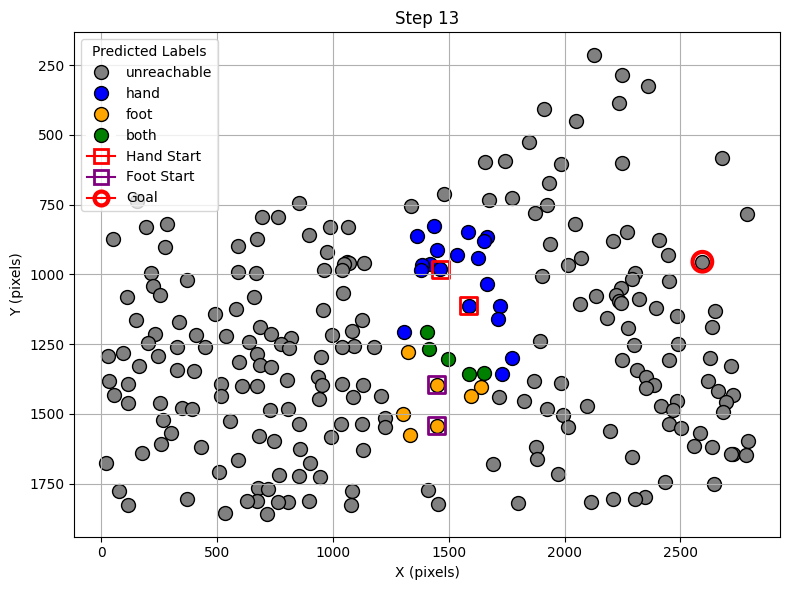

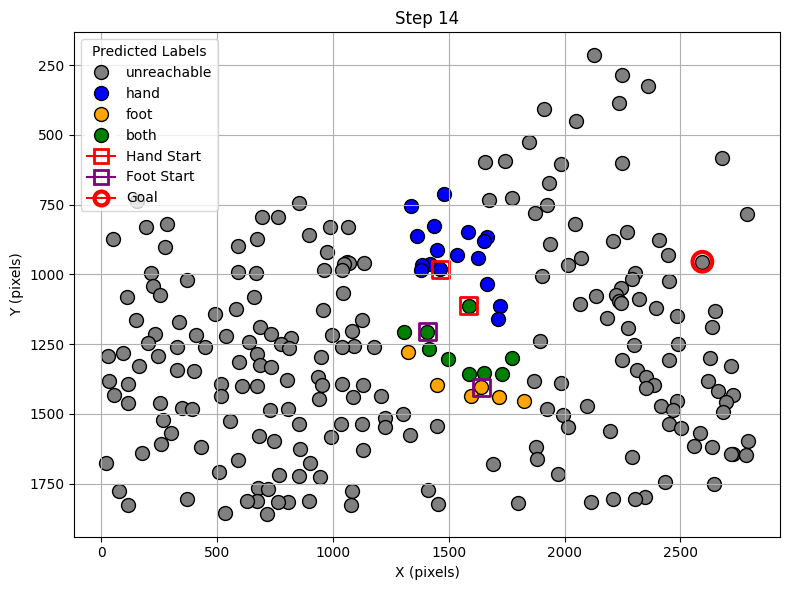

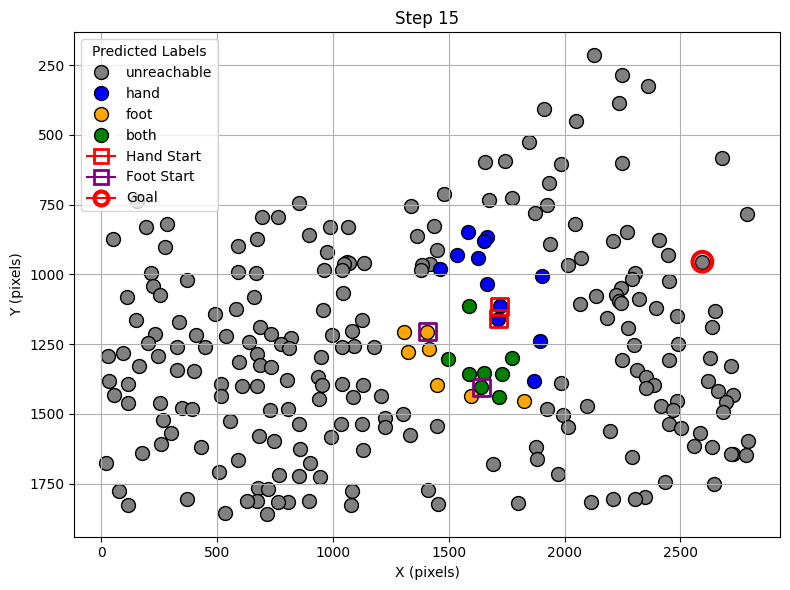

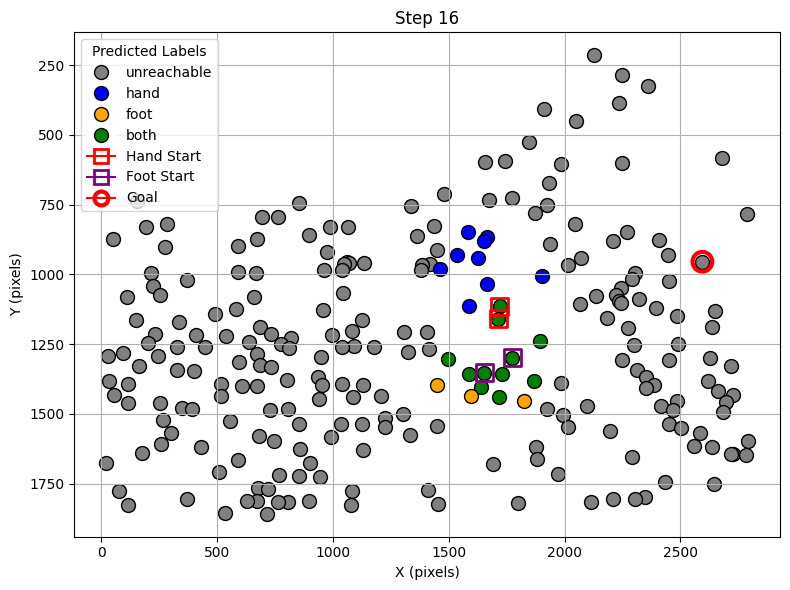

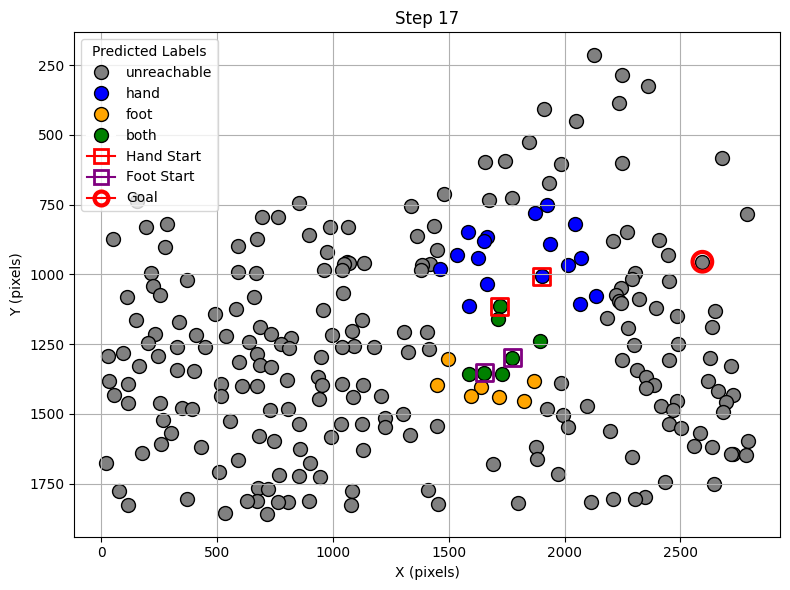

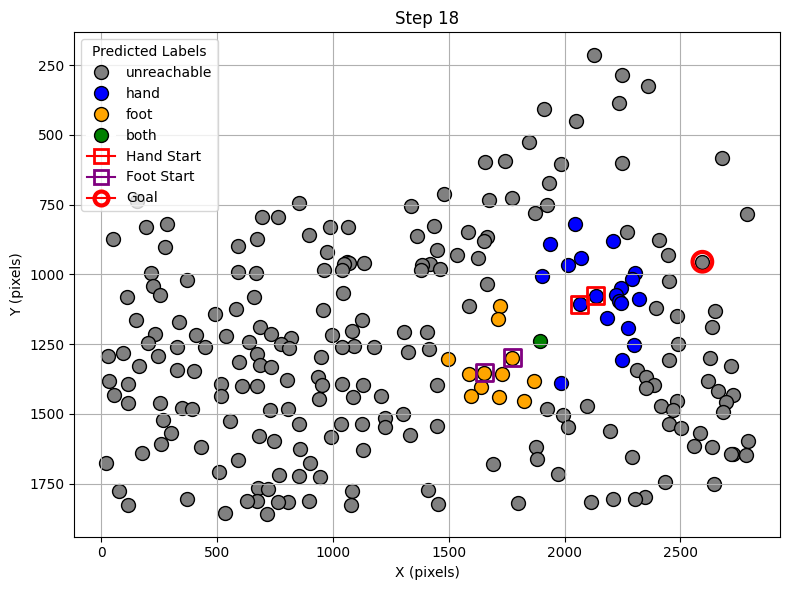

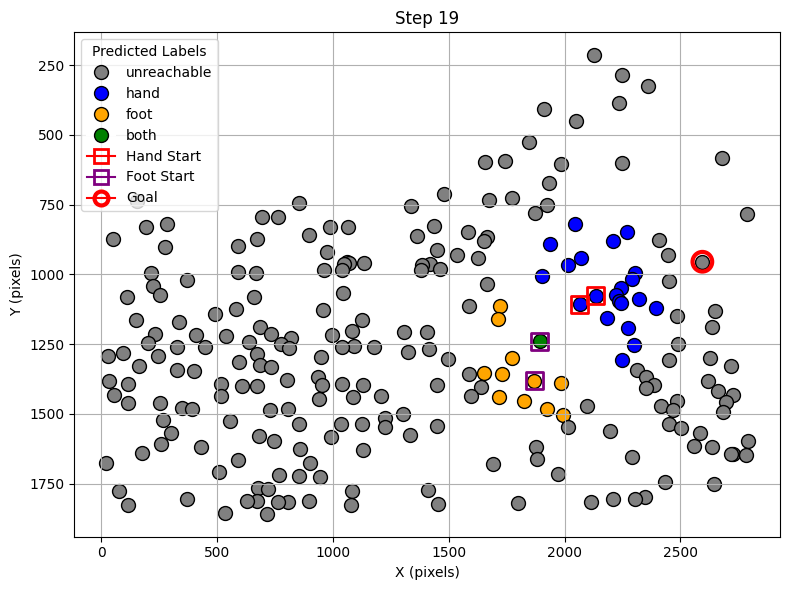

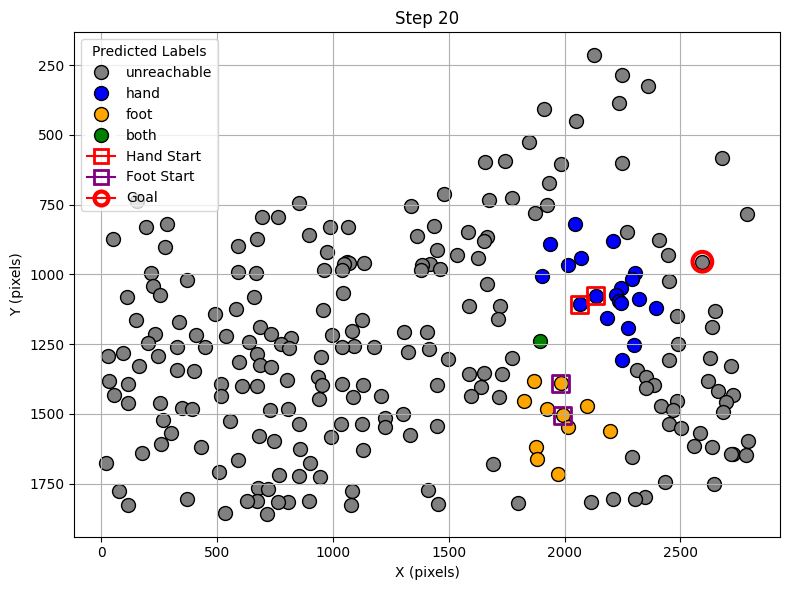

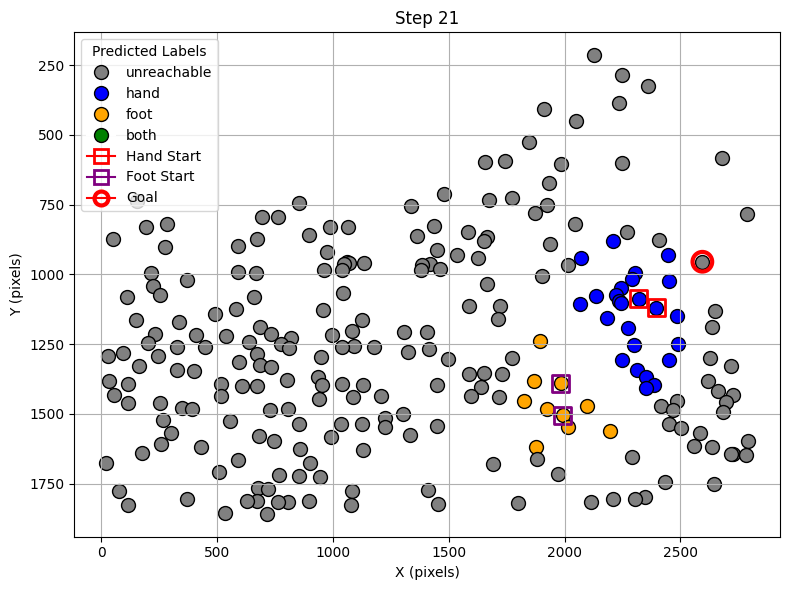

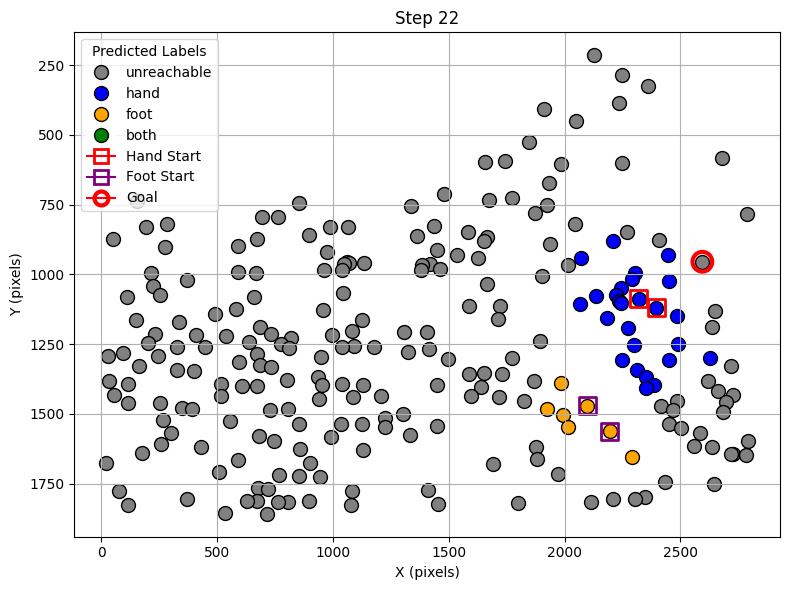

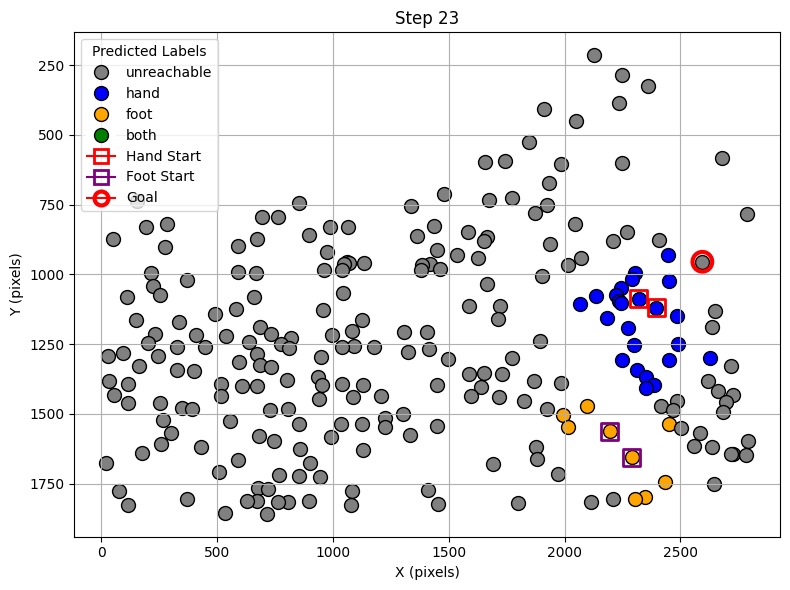

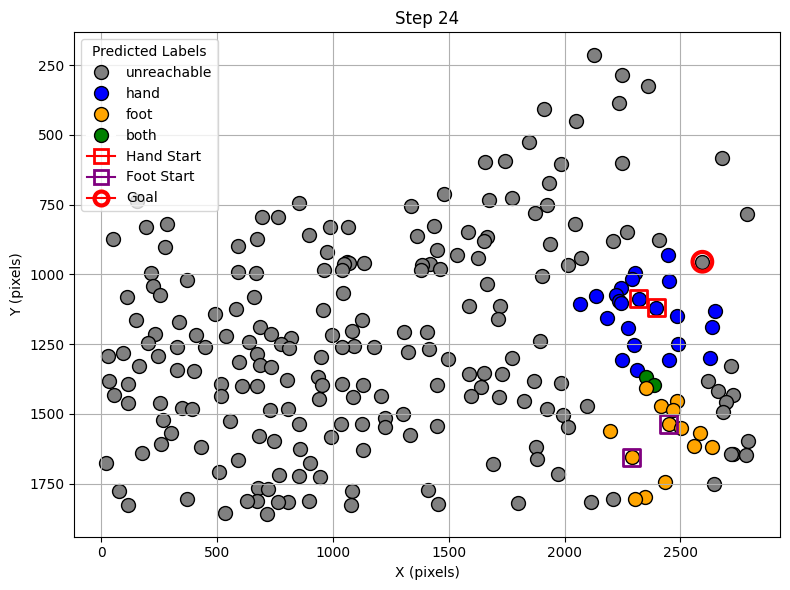

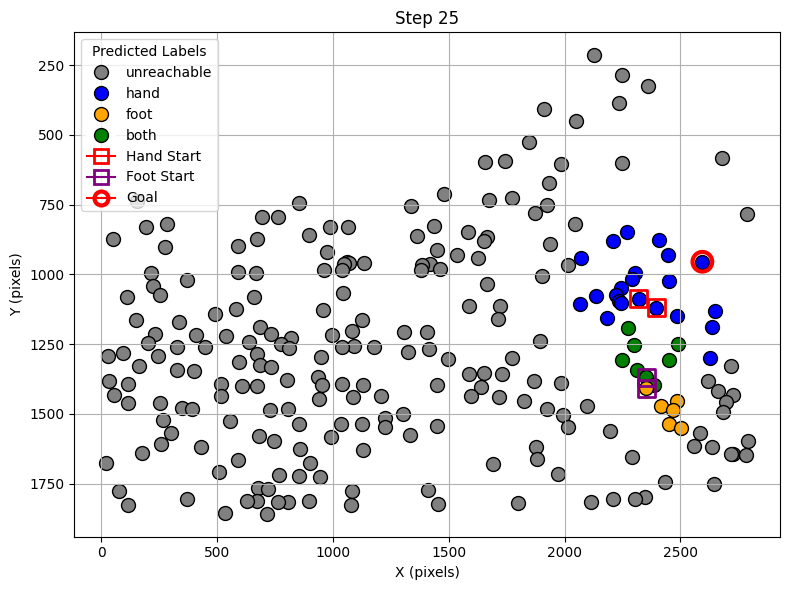

Success: Model predict climber can reach the goal (label=1) in Step 25


In [51]:
"""
TODO: simulation for different body types and creating figures/graphs 
showing how these differences influence things like `number of steps to goal`.

TODO: I would suggest doing this process with some modifications 
        of the way different holds are chosen by the climber
      - e.g., always choosing the reachable hold closest to the goal, 
        or combining this with trying to remain upright
"""
simulate_climb_to_goal_v2(batch1, model, goal)

# 统计不同climber在同一面墙到达终点的步数 1

In [5]:
walls = pd.read_csv("../data/climbing_data.csv")
walls["points"] = walls["points"].apply(literal_eval)

climber = {
    "height": 163.0,
    "ape_index": 0.9900,
    "flexibility": 4.000,
    "leg_len_factor": 0.5002,
    "arm_span": 163.0 * 0.9900,
    "leg_span": 163.0 * 0.5002
}
route = walls.iloc[3].points
# hands = [(22.181818181818183, 1676.3636363636363),(175.33333333333334, 1642.1666666666667)]
# feet = [(113.63636363636364, 1826.5454545454545), (77.6923076923077, 1775.0)]
# goal = (2360.25, 326.1666666666667)

hands = [(392.90909090909093, 1483.6363636363637), (349.0, 1480.3076923076924)]
feet = [(429.7692307692308, 1620.0), (175.33333333333334, 1642.1666666666667)]
goal = (2595.2727272727275, 954.9090909090909)

graph = build_single_graph_reachability(route, hands, feet, climber)

In [6]:
climbers = pd.read_csv("../data/all_climbers.csv").drop(columns=["Unnamed: 0"])
casuals = climbers.iloc[0:100]
skilleds = climbers.iloc[100:200]
elites = climbers.iloc[200:300]

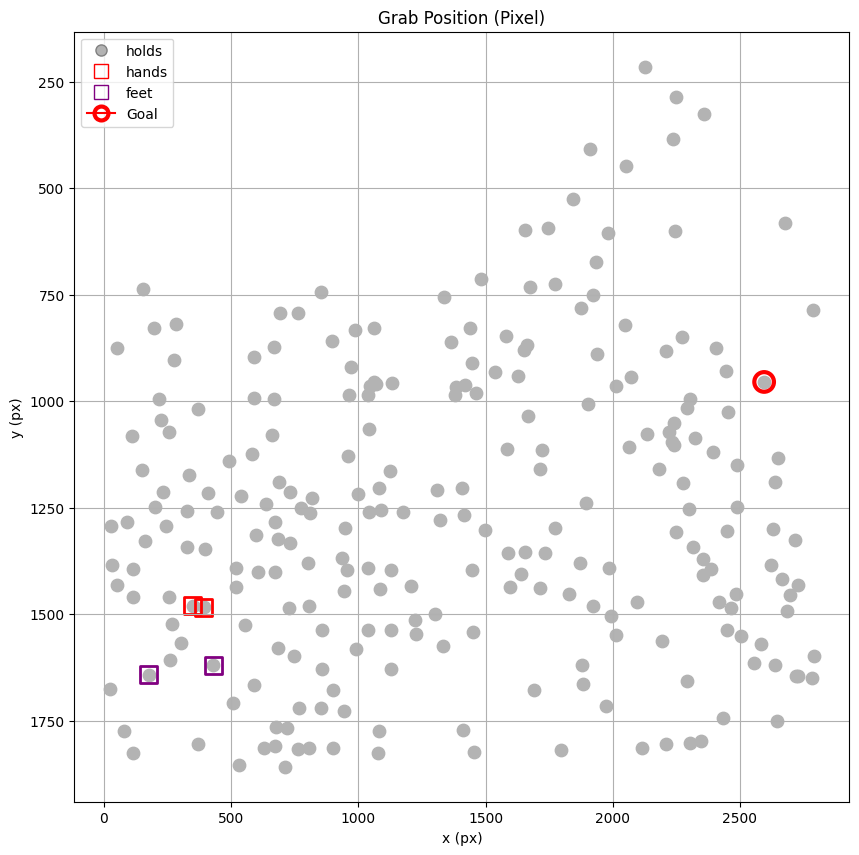

In [7]:
from dataset_function import plot_route_with_grab
plot_route_with_grab(route, hands, feet, goal=goal)

- Version 1

In [54]:
casual_steps = []
skilled_steps = []
elite_steps = []

g1 = copy.deepcopy(graph)

# For Casual
for _, climber in casuals.iterrows():
    g1.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g1)
    batch1 = Batch.from_data_list([g1])
    casual_steps.append(calculate_the_step_to_goal(batch1, model, goal))

# For Skilled
for _, climber in skilleds.iterrows():
    g1.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g1)
    batch1 = Batch.from_data_list([g1])
    skilled_steps.append(calculate_the_step_to_goal(batch1, model, goal))

# For Elite
for _, climber in elites.iterrows():
    g1.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g1)
    batch1 = Batch.from_data_list([g1])
    elite_steps.append(calculate_the_step_to_goal(batch1, model, goal))

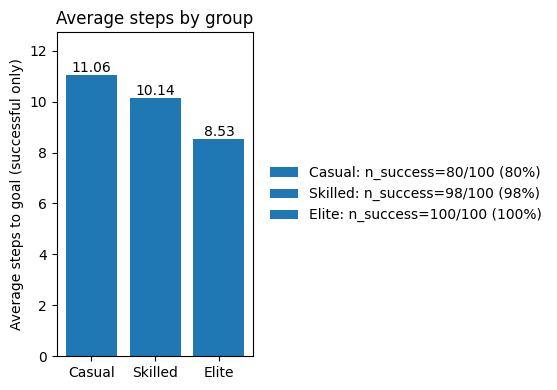

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def success_mean(arr):
    a = np.asarray(arr)
    ok = a[a >= 0]                 # 只保留成功（非 -1）
    return (np.mean(ok) if ok.size > 0 else np.nan, ok.size, a.size)

(c_mean, c_ok, c_total) = success_mean(casual_steps)
(s_mean, s_ok, s_total) = success_mean(skilled_steps)
(e_mean, e_ok, e_total) = success_mean(elite_steps)

labels  = ['Casual', 'Skilled', 'Elite']
means  = [c_mean, s_mean, e_mean]
rates   = [c_ok / c_total if c_total else 0,
           s_ok / s_total if s_total else 0,
           e_ok / e_total if e_total else 0]

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(labels, means)

ax.set_ylabel('Average steps to goal (successful only)')
ax.set_title('Average steps by group')

# 顶部留白，避免数值/图例被裁剪
finite_vals = [v for v in means if np.isfinite(v)]
ymax = max(finite_vals) if finite_vals else 1.0
ax.set_ylim(0, ymax * 1.15)

# 柱顶标注；无成功样本则标 N/A（放在底部稍上）
ymin, ymax = ax.get_ylim()
for b, v in zip(bars, means):
    if np.isfinite(v):
        ax.text(b.get_x()+b.get_width()/2, v, f'{v:.2f}',
                ha='center', va='bottom')
    else:
        ax.text(b.get_x()+b.get_width()/2, ymin + 0.02*(ymax-ymin), 'N/A',
                ha='center', va='bottom')

# 图例放到图外上方，三列横排，不遮挡
legend_labels = [
    f'Casual: n_success={c_ok}/{c_total} ({rates[0]:.0%})',
    f'Skilled: n_success={s_ok}/{s_total} ({rates[1]:.0%})',
    f'Elite: n_success={e_ok}/{e_total} ({rates[2]:.0%})'
]
for b, lab in zip(bars, legend_labels):
    b.set_label(lab)

ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# 给右边留空间，避免被裁剪
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

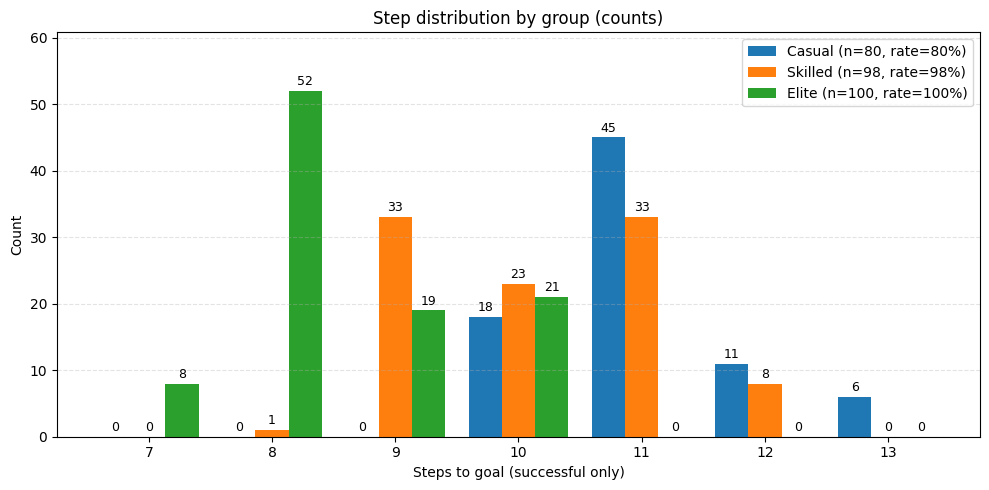

In [56]:
from reachability_model_function import plot_grouped_step_bars_counts
plot_grouped_step_bars_counts(casual_steps, skilled_steps, elite_steps)

- Version 2

In [57]:
casual_steps = []
skilled_steps = []
elite_steps = []

g1 = copy.deepcopy(graph)

# For Casual
for _, climber in casuals.iterrows():
    g1.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g1)
    batch1 = Batch.from_data_list([g1])
    casual_steps.append(calculate_the_step_to_goal_v2(batch1, model, goal))

# For Skilled
for _, climber in skilleds.iterrows():
    g1.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g1)
    batch1 = Batch.from_data_list([g1])
    skilled_steps.append(calculate_the_step_to_goal_v2(batch1, model, goal))

# For Elite
for _, climber in elites.iterrows():
    g1.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g1)
    batch1 = Batch.from_data_list([g1])
    elite_steps.append(calculate_the_step_to_goal_v2(batch1, model, goal))

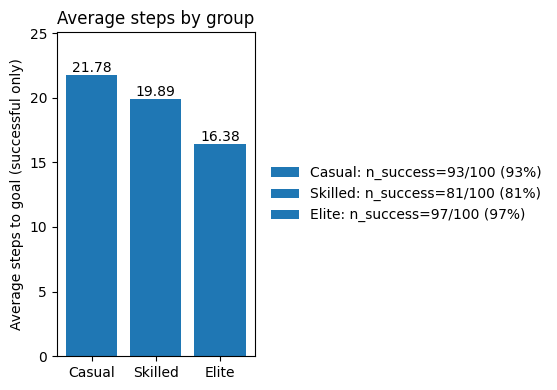

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def success_mean(arr):
    a = np.asarray(arr)
    ok = a[a >= 0]                 # 只保留成功（非 -1）
    return (np.mean(ok) if ok.size > 0 else np.nan, ok.size, a.size)

(c_mean, c_ok, c_total) = success_mean(casual_steps)
(s_mean, s_ok, s_total) = success_mean(skilled_steps)
(e_mean, e_ok, e_total) = success_mean(elite_steps)

labels  = ['Casual', 'Skilled', 'Elite']
means  = [c_mean, s_mean, e_mean]
rates   = [c_ok / c_total if c_total else 0,
           s_ok / s_total if s_total else 0,
           e_ok / e_total if e_total else 0]

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(labels, means)

ax.set_ylabel('Average steps to goal (successful only)')
ax.set_title('Average steps by group')

# 顶部留白，避免数值/图例被裁剪
finite_vals = [v for v in means if np.isfinite(v)]
ymax = max(finite_vals) if finite_vals else 1.0
ax.set_ylim(0, ymax * 1.15)

# 柱顶标注；无成功样本则标 N/A（放在底部稍上）
ymin, ymax = ax.get_ylim()
for b, v in zip(bars, means):
    if np.isfinite(v):
        ax.text(b.get_x()+b.get_width()/2, v, f'{v:.2f}',
                ha='center', va='bottom')
    else:
        ax.text(b.get_x()+b.get_width()/2, ymin + 0.02*(ymax-ymin), 'N/A',
                ha='center', va='bottom')

# 图例放到图外上方，三列横排，不遮挡
legend_labels = [
    f'Casual: n_success={c_ok}/{c_total} ({rates[0]:.0%})',
    f'Skilled: n_success={s_ok}/{s_total} ({rates[1]:.0%})',
    f'Elite: n_success={e_ok}/{e_total} ({rates[2]:.0%})'
]
for b, lab in zip(bars, legend_labels):
    b.set_label(lab)

ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# 给右边留空间，避免被裁剪
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

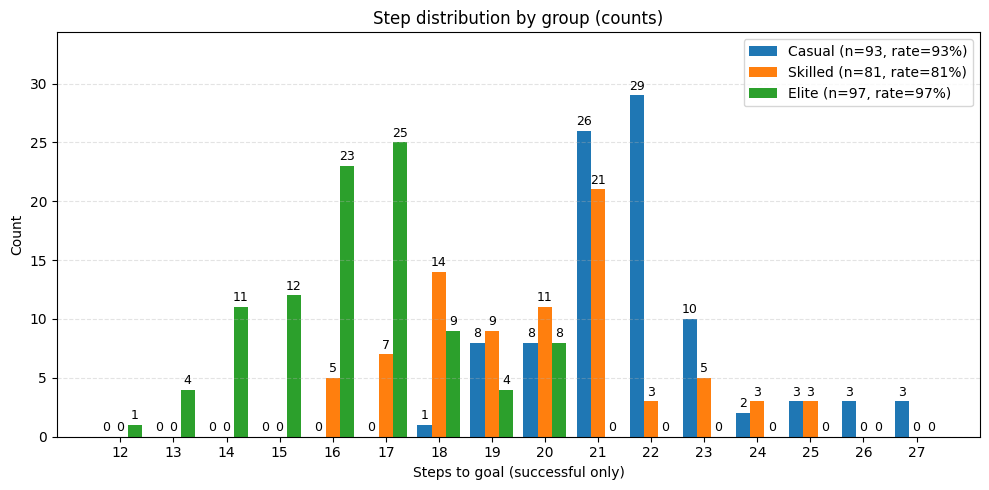

In [59]:
from reachability_model_function import plot_grouped_step_bars_counts
plot_grouped_step_bars_counts(casual_steps, skilled_steps, elite_steps)

# 统计不同climber在同一面墙到达终点的步数 2

In [8]:
walls = pd.read_csv("../data/climbing_data.csv")
walls["points"] = walls["points"].apply(literal_eval)

climber = {
    "height": 163.0,
    "ape_index": 0.9900,
    "flexibility": 4.000,
    "leg_len_factor": 0.5002,
    "arm_span": 163.0 * 0.9900,
    "leg_span": 163.0 * 0.5002
}
route = walls.iloc[2].points
# hands = [(22.181818181818183, 1676.3636363636363),(175.33333333333334, 1642.1666666666667)]
# feet = [(113.63636363636364, 1826.5454545454545), (77.6923076923077, 1775.0)]
# goal = (2360.25, 326.1666666666667)

hands = [(464.35714285714283, 987.7142857142857), (522.6842105263158, 983.421052631579)]
feet = [(585.5294117647059, 1204.5882352941176), (492.73333333333335, 1146.0)]
goal = (2517.25, 36.75)

graph2 = build_single_graph_reachability(route, hands, feet, climber)

In [9]:
climbers = pd.read_csv("../data/all_climbers.csv").drop(columns=["Unnamed: 0"])
casuals = climbers.iloc[0:100]
skilleds = climbers.iloc[100:200]
elites = climbers.iloc[200:300]

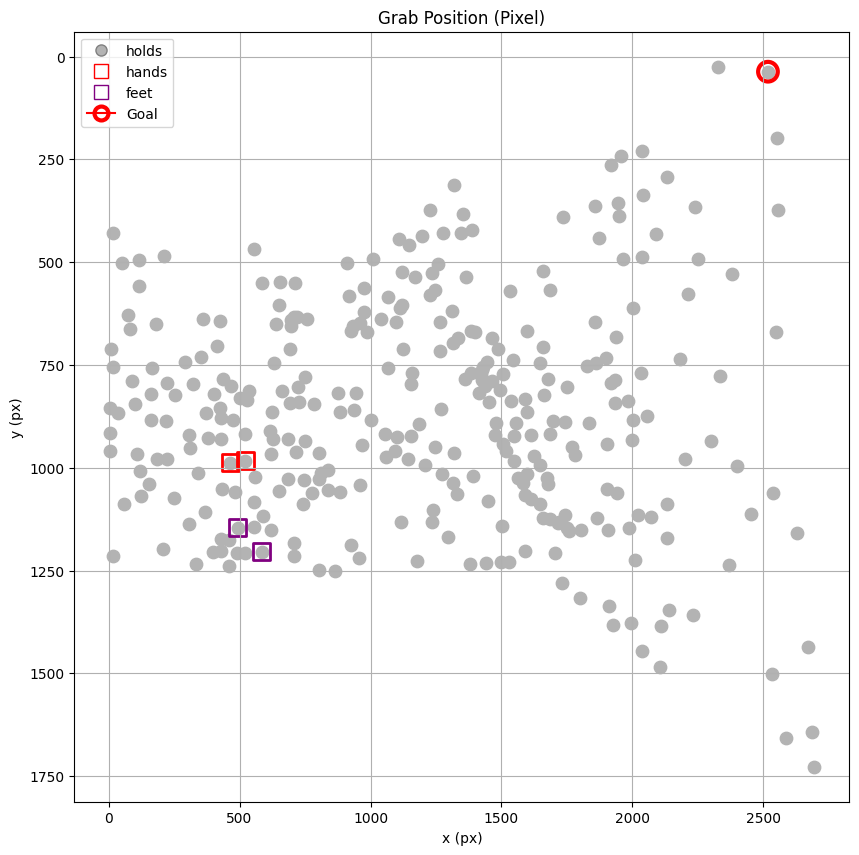

In [10]:
from dataset_function import plot_route_with_grab
plot_route_with_grab(route, hands, feet, goal=goal)

- Version 1

In [62]:
casual_steps2 = []
skilled_steps2 = []
elite_steps2 = []

g2 = copy.deepcopy(graph2)

# For Casual
for _, climber in casuals.iterrows():
    g2.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g2)
    batch2 = Batch.from_data_list([g2])
    casual_steps2.append(calculate_the_step_to_goal(batch2, model, goal))

# For Skilled
for _, climber in skilleds.iterrows():
    g2.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g2)
    batch2 = Batch.from_data_list([g2])
    skilled_steps2.append(calculate_the_step_to_goal(batch2, model, goal))

# For Elite
for _, climber in elites.iterrows():
    g2.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g2)
    batch2 = Batch.from_data_list([g2])
    elite_steps2.append(calculate_the_step_to_goal(batch2, model, goal))

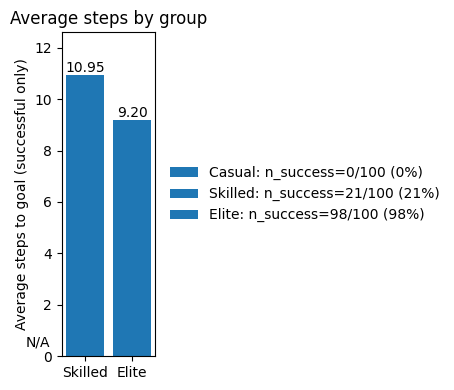

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def success_mean(arr):
    a = np.asarray(arr)
    ok = a[a >= 0]                 # 只保留成功（非 -1）
    return (np.mean(ok) if ok.size > 0 else np.nan, ok.size, a.size)

(c_mean2, c_ok, c_total) = success_mean(casual_steps2)
(s_mean2, s_ok, s_total) = success_mean(skilled_steps2)
(e_mean2, e_ok, e_total) = success_mean(elite_steps2)

labels  = ['Casual', 'Skilled', 'Elite']
means2  = [c_mean2, s_mean2, e_mean2]
rates   = [c_ok / c_total if c_total else 0,
           s_ok / s_total if s_total else 0,
           e_ok / e_total if e_total else 0]

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(labels, means2)

ax.set_ylabel('Average steps to goal (successful only)')
ax.set_title('Average steps by group')

# 顶部留白，避免数值/图例被裁剪
finite_vals = [v for v in means2 if np.isfinite(v)]
ymax = max(finite_vals) if finite_vals else 1.0
ax.set_ylim(0, ymax * 1.15)

# 柱顶标注；无成功样本则标 N/A（放在底部稍上）
ymin, ymax = ax.get_ylim()
for b, v in zip(bars, means2):
    if np.isfinite(v):
        ax.text(b.get_x()+b.get_width()/2, v, f'{v:.2f}',
                ha='center', va='bottom')
    else:
        ax.text(b.get_x()+b.get_width()/2, ymin + 0.02*(ymax-ymin), 'N/A',
                ha='center', va='bottom')

# 图例放到图外上方，三列横排，不遮挡
legend_labels = [
    f'Casual: n_success={c_ok}/{c_total} ({rates[0]:.0%})',
    f'Skilled: n_success={s_ok}/{s_total} ({rates[1]:.0%})',
    f'Elite: n_success={e_ok}/{e_total} ({rates[2]:.0%})'
]
for b, lab in zip(bars, legend_labels):
    b.set_label(lab)

ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# 给右边留空间，避免被裁剪
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

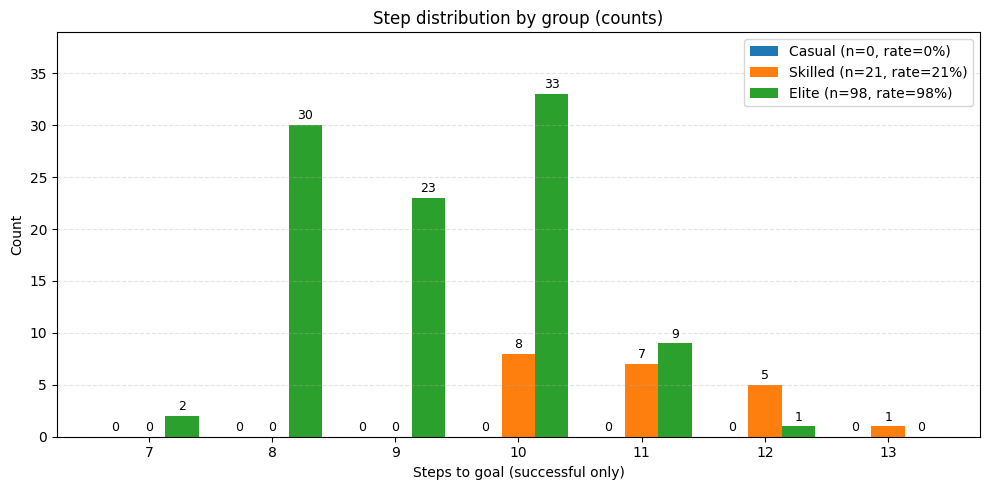

In [64]:
from reachability_model_function import plot_grouped_step_bars_counts
plot_grouped_step_bars_counts(casual_steps2, skilled_steps2, elite_steps2)

- Version 2

In [65]:
casual_steps2 = []
skilled_steps2 = []
elite_steps2 = []

g2 = copy.deepcopy(graph2)

# For Casual
for _, climber in casuals.iterrows():
    g2.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g2)
    batch2 = Batch.from_data_list([g2])
    casual_steps2.append(calculate_the_step_to_goal_v2(batch2, model, goal))

# For Skilled
for _, climber in skilleds.iterrows():
    g2.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g2)
    batch2 = Batch.from_data_list([g2])
    skilled_steps2.append(calculate_the_step_to_goal_v2(batch2, model, goal))

# For Elite
for _, climber in elites.iterrows():
    g2.climber = torch.tensor([[climber["height"],
                                climber["ape_index"],
                                climber["flexibility"],
                                climber["leg_len_factor"],
                                climber["height"] * climber["ape_index"],
                                climber["height"] * climber["leg_len_factor"]
                                ]])
    recompute_node_features_with_climber(g2)
    batch2 = Batch.from_data_list([g2])
    elite_steps2.append(calculate_the_step_to_goal_v2(batch2, model, goal))

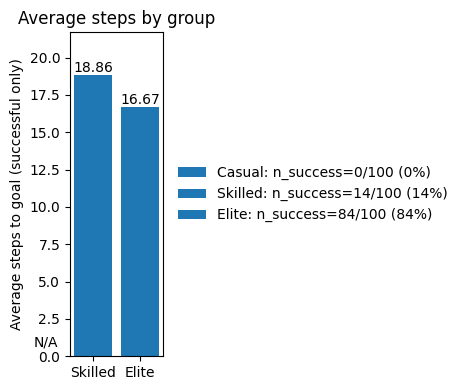

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def success_mean(arr):
    a = np.asarray(arr)
    ok = a[a >= 0]                 # 只保留成功（非 -1）
    return (np.mean(ok) if ok.size > 0 else np.nan, ok.size, a.size)

(c_mean2, c_ok, c_total) = success_mean(casual_steps2)
(s_mean2, s_ok, s_total) = success_mean(skilled_steps2)
(e_mean2, e_ok, e_total) = success_mean(elite_steps2)

labels  = ['Casual', 'Skilled', 'Elite']
means2  = [c_mean2, s_mean2, e_mean2]
rates   = [c_ok / c_total if c_total else 0,
           s_ok / s_total if s_total else 0,
           e_ok / e_total if e_total else 0]

fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(labels, means2)

ax.set_ylabel('Average steps to goal (successful only)')
ax.set_title('Average steps by group')

# 顶部留白，避免数值/图例被裁剪
finite_vals = [v for v in means2 if np.isfinite(v)]
ymax = max(finite_vals) if finite_vals else 1.0
ax.set_ylim(0, ymax * 1.15)

# 柱顶标注；无成功样本则标 N/A（放在底部稍上）
ymin, ymax = ax.get_ylim()
for b, v in zip(bars, means2):
    if np.isfinite(v):
        ax.text(b.get_x()+b.get_width()/2, v, f'{v:.2f}',
                ha='center', va='bottom')
    else:
        ax.text(b.get_x()+b.get_width()/2, ymin + 0.02*(ymax-ymin), 'N/A',
                ha='center', va='bottom')

# 图例放到图外上方，三列横排，不遮挡
legend_labels = [
    f'Casual: n_success={c_ok}/{c_total} ({rates[0]:.0%})',
    f'Skilled: n_success={s_ok}/{s_total} ({rates[1]:.0%})',
    f'Elite: n_success={e_ok}/{e_total} ({rates[2]:.0%})'
]
for b, lab in zip(bars, legend_labels):
    b.set_label(lab)

ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

# 给右边留空间，避免被裁剪
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()

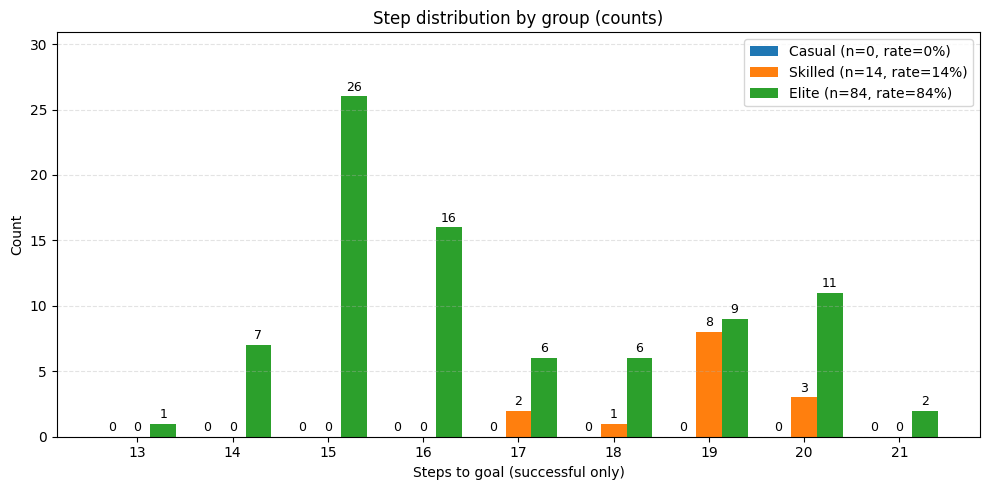

In [67]:
from reachability_model_function import plot_grouped_step_bars_counts
plot_grouped_step_bars_counts(casual_steps2, skilled_steps2, elite_steps2)